# 1.d. Result data management


Now that the simulation has been completed through 1.c. Continuous reservoir simulations, this section will guide you in generating the result data and visualizing the outcomes. 

## 1. Import libraries

We start to importing the necessary libraries and tools (🚨 in order to run the code like in the box below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from platypus import NSGAII, Problem, Real
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import calendar
from datetime import date
from dateutil.relativedelta import relativedelta
from irons.Software.read_data import read_csv_data
from irons.Software.day2week2month import day2week
from irons.Software.res_sys_sim import res_sys_sim
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Rectangle
path = os.getcwd()

## 2. Reservoir simulation settings

Specify the details of the reservoir simulations, including parameters such as storage names, capacity constraints, and release constraints.

In [4]:
# Define the flow scenario or forecast used in the analysis
scenario_list = {1:'1. Perfect forecast scenario', 2:'2. Worst case scenario', 3:'3. 20-year drought', 4:'4. ESP', 5:'5. SFFs'} 
# Define the MCDM method used in the analysis. Details of these MCDM methods will be explained in the next notebook.
MCDM_list = {1:'saw_bal', 2:'saw_sup', 3:'saw_sto', 4:'vw_select', 5:'vw_multi', 6:'rp_utopia', 7:'rp_knee', 8:'rp_topsis'}

# Define reservoir characteristic
reservoir_name = 'A'
s_min = 337               # Minimum Storage volume (Million Cubic Meters)
s_max = 4349              # Maximum Storage volume (Million Cubic Meters)
Q_max = 652               # Maximum regulated release (Million Cubic Meters/day)
env_min = 0               # Minimum environmental release (MCM/d)
Qreg_s_D_min = 0          # Minumum regulated release (MCM/d)
Qreg_s_D_max = Q_max      # Maximum regulated release (MCM/d)

# Details on the initial reservoir release optimisation
start_year = 2014
start_month = 6
end_year = 2016
end_month = 9

catchment_area = 9351 # Catchmnet area of the reservoir (km2)

## 3. Combine the results along the simulation periods

For better analysis of reservoir simulations generated using different experimental choices, it is important to combine the multiple results generated every month. The following code helps you to rearrange the results and save it as a single csv file. Please note that you can run this code when you complete the simulations with different lead time (2,4,6) and decision-making time step (1,2).

In [5]:
# Simulated results for lead times and decision times
for leadtime in [2,4,6]:  # Iterate through different lead times
    for decision_time in [1,2]:  # Iterate through different decision times (monthly or bi-monthly)
        # Calculate the total number of months based on the decision time and the start and end dates
        total_months = int(((end_year - start_year) * 12 + (end_month - start_month) + 1)/decision_time)
        
        for scenario in range(1, 6):  # Iterate through each scenario (e.g., 5 scenarios)
            for MCDM in range(1, 9):  # Iterate through each multi-criteria decision method (MCDM)
                year = start_year
                month = start_month
                temp = pd.DataFrame()

                # Define paths for simulated data
                path_sim = path + '/data/' + scenario_list[scenario] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM]
                path_obs  = path + '/data/' 

                for _ in range(total_months):  # Loop through the number of months

                    # Read the simulation result for a specific year, month, and decision time
                    df = pd.read_csv(path_sim + '/[Res_operation]' + reservoir_name + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_opt.csv', index_col=0)
                    sim = df.loc['Release'].reset_index(drop=True).rename(columns={df.columns[0]:'Release'})  # Extract release data
                    sim['I_obs'] = df.loc['I_obs'].reset_index(drop=True)  # Extract observed inflow data
                    sim['Demand'] = df.loc['Demand'].reset_index(drop=True)  # Extract demand data
                    sim['Storage'] = df.loc['Storage'].reset_index(drop=True)  # Extract storage data
                    sim['Volume Difference'] = df.loc['Volume Difference'][1:].reset_index(drop=True)  # Extract volume difference (exclude first row)
                    sim['Supply Deficit'] = df.loc['Supply Deficit'].reset_index(drop=True)  # Extract supply deficit data

                    # Handle initial month case for proper indexing
                    if year == start_year and month == start_month:
                        n = 0
                    else:
                        n = 1

                    sim = sim[n:decision_time*4+1].reset_index(drop=True)  # Select the necessary data for decision time period

                    # Update the month and year for the next iteration
                    if month + decision_time > 12:
                        year += 1
                        month = month + decision_time - 12
                    else:
                        month += decision_time

                    temp = pd.concat([temp, sim], axis=0).reset_index(drop=True)  # Concatenate results for each month

                # Save the merged simulated data for this scenario and MCDM method
                sim_merg = temp.round(2)  # Round values to 2 decimal places
                sim_merg.to_csv(path_sim + '/[Res_operation]' + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv')

# For observed data processing
for decision_time in [1,2]:  # Iterate through different decision times (monthly or bi-monthly)
    # Calculate the total number of months based on the decision time and the start and end dates
    total_months = int(((end_year - start_year) * 12 + (end_month - start_month) + 1)/decision_time)
    temp_obs = pd.DataFrame()
    year = start_year
    month = start_month
    for _ in range(total_months):  # Loop through the number of months
        # Read the observed data
        df_obs = pd.read_csv(path + '/data/observed_data.csv')
        df_obs['Date'] = pd.to_datetime(df_obs['Date'])  # Convert the Date column to datetime format
        start_date = pd.Timestamp(year=year, month=month, day=1)  # Define the start date for each iteration

        # Filter the observed data starting from the defined start date
        df_obs_filtered = df_obs[df_obs['Date'] >= start_date].copy()
        df_obs_filtered['week'] = ((df_obs_filtered['Date'] - start_date).dt.days // 7) + 1  # Calculate the week number from the start date

        # Aggregate data on a weekly basis for inflow, outflow, and storage
        weekly_obs = df_obs_filtered.groupby('week').agg({
            'inflow': 'sum',  # Sum the inflow for each week
            'outflow': 'sum',  # Sum the outflow for each week
            'sto': 'last'  # Get the last storage value of the week
        }).reset_index()

        # Get the storage value for the start date
        start_date_sto = df_obs_filtered[df_obs_filtered['Date'] == start_date]['sto']

        # Create the first week's data
        weekly_obs_first = pd.DataFrame({
            'week': [0],  # Set week 0
            'inflow': [0],  # Set inflow to 0 for week 0
            'outflow': [0],  # Set outflow to 0 for week 0
            'sto': [start_date_sto.values[0]]  # Set the storage to the value at the start date
        })

        # For the first year and month, concatenate week 0 data with the rest of the weekly data
        if year == start_year and month == start_month:
            obs_i = pd.concat([weekly_obs_first, weekly_obs], axis=0).reset_index(drop=True)
            obs = obs_i[0:decision_time*4+1].reset_index(drop=True)  # Select the necessary number of weeks for decision time period
        else:
            obs = weekly_obs[0:decision_time*4].reset_index(drop=True)  # For subsequent months, only select the relevant weeks

        # Update the month and year for the next iteration
        if month + decision_time > 12:
            year += 1
            month = month + decision_time - 12
        else:
            month += decision_time

        temp_obs = pd.concat([temp_obs, obs], axis=0)  # Concatenate results for each month

    # Rename columns and calculate the volume difference and supply deficit
    obs_merg = temp_obs.rename(columns={'week':'week', 'inflow':'I_obs', 'outflow':'Release', 'sto':'Storage'}).drop(temp_obs.columns[0], axis=1).reset_index(drop=True)
    obs_merg['Demand'] = sim_merg['Demand']  # Add demand data from simulated results
    obs_merg['Volume Difference'] = (s_max - obs_merg['Storage']).clip(lower=0)  # Calculate volume difference
    obs_merg['Supply Deficit'] = (obs_merg['Demand'] - obs_merg['Release']).clip(lower=0)  # Calculate supply deficit

    # Reorder columns and save the merged observed data
    neworder = [1,0,3,2,4,5]  # Define a new column order
    obs_merg = obs_merg[obs_merg.columns[neworder]]
    obs_merg.to_csv(path_obs + '/[Res_operation]' + reservoir_name + '_decision_' + str(decision_time) + 'm_obs_merged.csv')

print("Successful")

Successful


## 4. Visualisation

Here, we will visulaise the value assessment results. For more details regarding reference figures, please refer to following paper.
* Lee, Y., Peñuela, A., Pianosi, F., and Angel Rico-Ramirez, M.: Value of seasonal flow forecasts for enhancing reservoir operation and drought management in South Korea, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2024-1985, 2024.

### 4.1 Accuracy of flow scenarios and forecasts

This figure (Figure 5 in the Reference paper) illustrates the Mean Error of monthly flow for lead times of 2, 4, 6 months and different type of flow forecast/scenario (WCD: yellow, 20YD: blue, ESP: pink, SFFs: green).

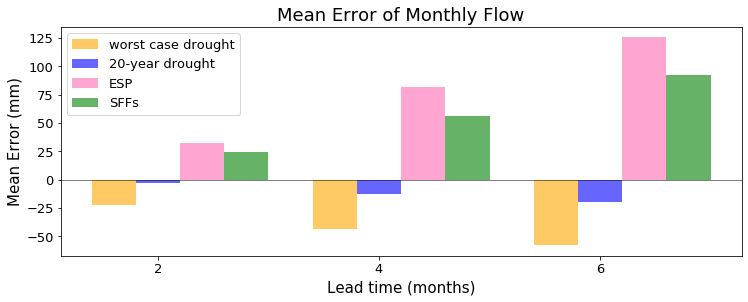

In [6]:
merged = pd.DataFrame()
meanerror = pd.DataFrame()

# Define month ranges for each year
month_ranges = {
    2014: [6, 7, 8, 9, 10, 11, 12],
    2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    2016: [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

path_pf =  path + '/data/' + scenario_list[1] + '/in/leadtime_' 
path_wc =  path + '/data/' + scenario_list[2] + '/in/leadtime_' 
path_d20 =  path + '/data/' + scenario_list[3] + '/in/leadtime_' 
path_esp =  path + '/data/' + scenario_list[4] + '/in/leadtime_' 
path_sffs =  path + '/data/' + scenario_list[5] + '/in/leadtime_' 

for leadtime in [2,4,6]:
    for year, months in month_ranges.items():
        for month in months:
            # Load data from each source
            chart_pf = pd.read_csv(f"{path_pf}{leadtime}/I_fore_{year}_{month}.csv")
            chart_wc = pd.read_csv(f"{path_wc}{leadtime}/I_fore_{year}_{month}.csv")
            chart_d20 = pd.read_csv(f"{path_d20}{leadtime}/I_fore_{year}_{month}.csv")
            chart_esp = pd.read_csv(f"{path_esp}{leadtime}/I_fore_{year}_{month}.csv")
            chart_sffs = pd.read_csv(f"{path_sffs}{leadtime}/I_fore_{year}_{month}.csv")

            chart_esp.loc['mean'] = chart_esp.sum(numeric_only=True)
            chart_sffs.loc['mean'] = chart_sffs.sum(numeric_only=True)

            # Prepare data for DataFrame
            data = {
                'year': year,
                'month': month,
                'leadtime': leadtime,
                'obs': chart_pf['I'].sum(),
                'wc': chart_wc['I'].sum(),
                'd20': chart_d20['I'].sum(),
                'esp': chart_esp.loc['mean'].median(),
                'sffs': chart_sffs.loc['mean'].median(),
            }

            # Append to merged DataFrame
            merged = pd.concat([merged, pd.DataFrame([data])], ignore_index=True)

meanerror = merged
meanerror['error_wc'] = (meanerror['wc'] - meanerror['obs'])
meanerror['error_d20'] = (meanerror['d20']-meanerror['obs'])
meanerror['error_esp'] = (meanerror['esp']-meanerror['obs'])
meanerror['error_sffs'] = (meanerror['sffs']-meanerror['obs'])

# Grouping by lead time and calculating the mean of the errors
df = meanerror.groupby(['leadtime']).mean().reset_index()
df = df.iloc[:,8:]*1000/catchment_area

# Prepare data for the bar chart
data = {
    'leadtime': [2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6],
    'accuracy': [df['error_wc'][0], df['error_wc'][1], df['error_wc'][2],
              df['error_d20'][0], df['error_d20'][1], df['error_d20'][2],
              df['error_esp'][0], df['error_esp'][1], df['error_esp'][2],
              df['error_sffs'][0], df['error_sffs'][1], df['error_sffs'][2]],
    'remark': ['worst case drought']*3 + ['20-year drought']*3 + ['ESP']*3 + ['SFFs']*3
}

df_f = pd.DataFrame(data)
df_f = df_f.sort_values(by='leadtime').reset_index(drop=True)


# Assign colors based on 'remark'
color_mapping = {
    'worst case drought': 'orange',
    '20-year drought': 'blue',
    'ESP': 'hotpink',
    'SFFs': 'green'
}

# Map colors based on the 'remark' column
colors = df_f['remark'].map(color_mapping)

# Create the bar chart
plt.figure(figsize=(10.5, 4.3))

# Define the positions for the bars
bar_width = 0.2  # Width of each bar
lead_times = df_f['leadtime'].unique()  # Unique lead times
x_positions = np.arange(len(lead_times))  # Positions for the lead times

# Loop through each remark type to plot the bars
for i, remark in enumerate(df_f['remark'].unique()):
    # Filter data for the current remark
    current_data = df_f[df_f['remark'] == remark]
    
    # Plot the bars at shifted positions
    plt.bar(x_positions + i * bar_width, current_data['accuracy'], width=bar_width, color=color_mapping[remark], label=remark, alpha=0.6)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Set x-ticks to correspond to the lead times
plt.xticks(x_positions + bar_width, lead_times)  # Adjust x-ticks

# Title and labels
plt.title('Mean Error of Monthly Flow', fontsize=18)
plt.xlabel('Lead time (months)', fontsize=15)
plt.ylabel('Mean Error (mm)', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Add a legend
plt.legend(fontsize=13)

# Show the plot
plt.tight_layout()        # Adjust layout to prevent clipping
plt.show()

### 4.2 Reservoir simulations and their performances

The simulated reservoir operation results are visualised here (Figure 5 in the reference paper), showing the storage volume (a) and cumulative squared supply deficit (b) generated using WCD (yellow), 20YD (blue), ESP (pink) and SFFs (green). For each flow forecast/scenario, there are 48 simulation outcomes resulting from different combinations of the experimental choices (3 lead times × 8 MCDM methods × 2 decision-making time steps). Higher storage volume compared to historical operation (black line) is preferable and vice versa for cumulative squared supply deficit.

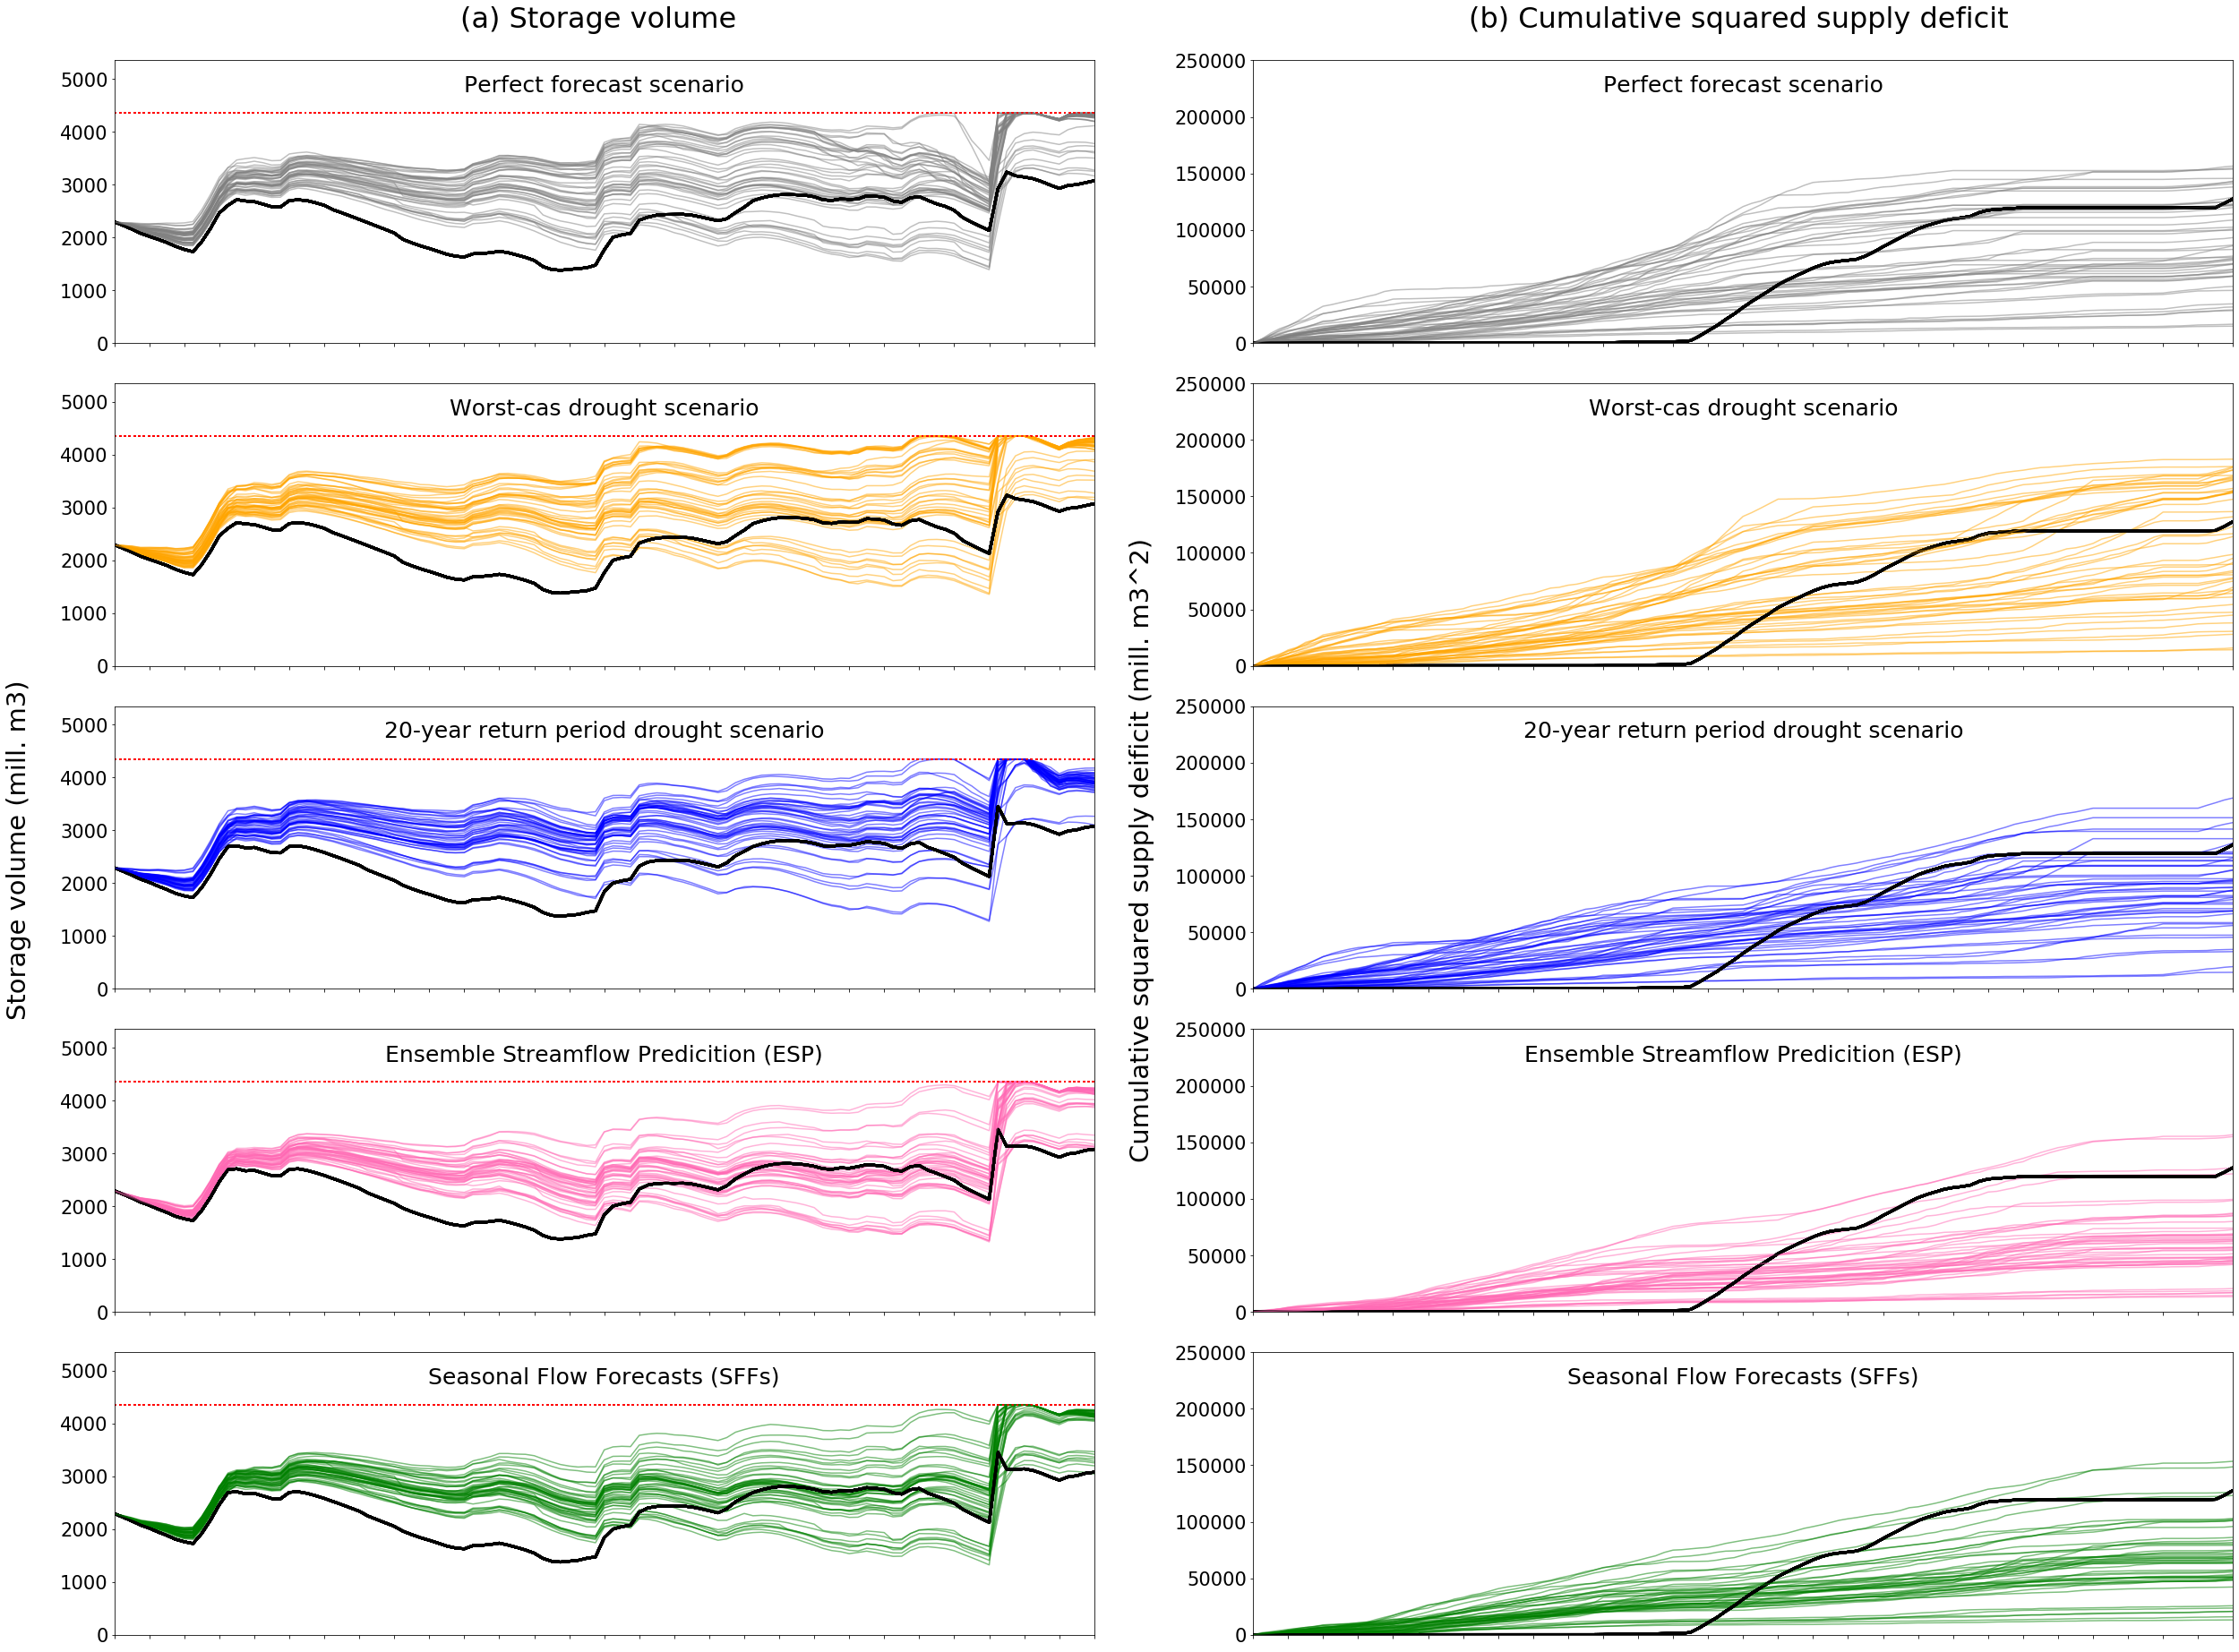

In [7]:
fig, axes = plt.subplots(5, 2, sharex=False, figsize=(17*2, 5.0*5))

sto_offset=1000
ssd_max = 250000

#------------------------------------------Storage------------------------------------------------------------------
plt.subplot(5,2,1)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[1] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                              + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)

            ax = plt.plot(obs.index+1, obs['Storage'], color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['Storage'], color='grey', linestyle='-', linewidth=1.5, label='perfect forecast', alpha=0.5)


            plt.axhline(y=s_max, color='red', lw=2, linestyle=':', alpha=0.7)  #수평 중앙선 삽입하기
            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Perfect forecast scenario', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.ylim(0,s_max+sto_offset)
            plt.xticks(visible=False)
            
plt.subplot(5,2,2)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[1] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                              + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)
            obs['SSD'] = obs['Supply Deficit']**2
            df['SSD'] = df['Supply Deficit']**2

            ax = plt.plot(obs.index+1, obs['SSD'].cumsum(), color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['SSD'].cumsum(), color='grey', linestyle='-', linewidth=1.5, label='perfect forecast', alpha=0.5)

            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Perfect forecast scenario', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.xticks(visible=False)
            plt.ylim(0,ssd_max)

plt.subplot(5,2,3)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[2] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                          + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)

            ax = plt.plot(obs.index+1, obs['Storage'], color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['Storage'], color='orange', linestyle='-', linewidth=1.5, label='worst case', alpha=0.5)


            plt.axhline(y=s_max, color='red', lw=2, linestyle=':', alpha=0.7)  #수평 중앙선 삽입하기
            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Worst-cas drought scenario', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.ylim(0,s_max+sto_offset)
            plt.xticks(visible=False)
            
plt.subplot(5,2,4)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[2] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                              + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)
            obs['SSD'] = obs['Supply Deficit']**2
            df['SSD'] = df['Supply Deficit']**2

            ax = plt.plot(obs.index+1, obs['SSD'].cumsum(), color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['SSD'].cumsum(), color='orange', linestyle='-', linewidth=1.5, label='perfect forecast', alpha=0.5)

            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Worst-cas drought scenario', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.xticks(visible=False)            
            plt.ylim(0,ssd_max)
                

plt.subplot(5,2,5)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(1) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[3] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                          + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)

            ax = plt.plot(obs.index+1, obs['Storage'], color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['Storage'], color='blue', linestyle='-', linewidth=1.5, label='20-year drought', alpha=0.5)

            plt.axhline(y=s_max, color='red', lw=2, linestyle=':', alpha=0.7)  #수평 중앙선 삽입하기
            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('20-year return period drought scenario', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.ylim(0,s_max+sto_offset)
            plt.xticks(visible=False)
            
            
plt.subplot(5,2,6)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[3] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                              + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)
            obs['SSD'] = obs['Supply Deficit']**2
            df['SSD'] = df['Supply Deficit']**2

            ax = plt.plot(obs.index+1, obs['SSD'].cumsum(), color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['SSD'].cumsum(), color='blue', linestyle='-', linewidth=1.5, label='perfect forecast', alpha=0.5)

            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('20-year return period drought scenario', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.xticks(visible=False)            
            plt.ylim(0,ssd_max)
                            
            
plt.subplot(5,2,7)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(1) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[4] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                          + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)

            ax = plt.plot(obs.index+1, obs['Storage'], color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['Storage'], color='hotpink', linestyle='-', linewidth=1.5, label='ESP', alpha=0.5)

            plt.axhline(y=s_max, color='red', lw=2, linestyle=':', alpha=0.7)  #수평 중앙선 삽입하기
            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Ensemble Streamflow Predicition (ESP)', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.ylim(0,s_max+sto_offset)
            plt.xticks(visible=False)
            
            
plt.subplot(5,2,8)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[4] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                              + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)
            obs['SSD'] = obs['Supply Deficit']**2
            df['SSD'] = df['Supply Deficit']**2

            ax = plt.plot(obs.index+1, obs['SSD'].cumsum(), color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['SSD'].cumsum(), color='hotpink', linestyle='-', linewidth=1.5, label='perfect forecast', alpha=0.5)

            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Ensemble Streamflow Predicition (ESP)', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.xticks(visible=False)          
            plt.ylim(0,ssd_max)
            
            
plt.subplot(5,2,9)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(1) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[5] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                          + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)

            ax = plt.plot(obs.index+1, obs['Storage'], color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['Storage'], color='green', linestyle='-', linewidth=1.5, label='ESP', alpha=0.5)

            plt.axhline(y=s_max, color='red', lw=2, linestyle=':', alpha=0.7)  #수평 중앙선 삽입하기
            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Seasonal Flow Forecasts (SFFs)', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.ylim(0,s_max+sto_offset)
            plt.xticks(visible=False)            
            
            
plt.subplot(5,2,10)
for MCDM in range(1,9):
    for leadtime in [2,4,6]:
        for decision_time in [1, 2]:
            obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
            df =  pd.read_csv(path + '/data/' + scenario_list[5] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                              + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)
            obs['SSD'] = obs['Supply Deficit']**2
            df['SSD'] = df['Supply Deficit']**2

            ax = plt.plot(obs.index+1, obs['SSD'].cumsum(), color='black', linestyle='-', linewidth=3, label='Observed', alpha=0.5)
            ax = plt.plot(df.index+1, df['SSD'].cumsum(), color='green', linestyle='-', linewidth=1.5, label='perfect forecast', alpha=0.5)

            plt.xticks(np.arange(1, obs.index.max()+2, step=4))
            plt.title('Seasonal Flow Forecasts (SFFs)', x=0.5, y=0.87, fontsize = 25)
            plt.ylabel(None)
            plt.xlabel(None)
            plt.xticks(fontsize=21)
            plt.yticks(fontsize=21)
            plt.margins(x=0.)
            plt.xticks(visible=False)
            plt.ylim(0,ssd_max)
            
fig.text(-0.02, 0.5, 'Storage volume (mill. m3)', va='center', rotation='vertical', fontsize=29)
fig.text(0.492, 0.5, 'Cumulative squared supply deificit (mill. m3^2)', va='center', rotation='vertical', fontsize=29)
fig.text(0.25, 1.01, '(a) Storage volume', ha='center', fontsize=32)
fig.text(0.77, 1.01, '(b) Cumulative squared supply deficit', ha='center', fontsize=32)
          
plt.tight_layout(h_pad=2.5, w_pad=9.0)
plt.show()

### 4.3 Value of Seasonal Flow Forecasts

This figure (Figure 6 in the reference paper) depicts the differences in achieved performance indicators (SSD and SVD) between simulated operations and historical operation at distinct time points X, Y and Z (see Figure 5), corresponding to the end of hydrological years (September 30th). Coloured circles in the figure denote the type of flow forecast/scenario used in simulations (following the same colour code as in Figure 5) and there are 48 circles (3×8×2) in each colour, corresponding to the combinations of 3 lead times, 8 MCDM methods and 2 decision-making time steps. Circles positioned below (above) zero for both the x and y axes, i.e. within the green (red) shaded area, indicate experiments where reservoir simulations achieve better (worse) performance compared to historical operation. 

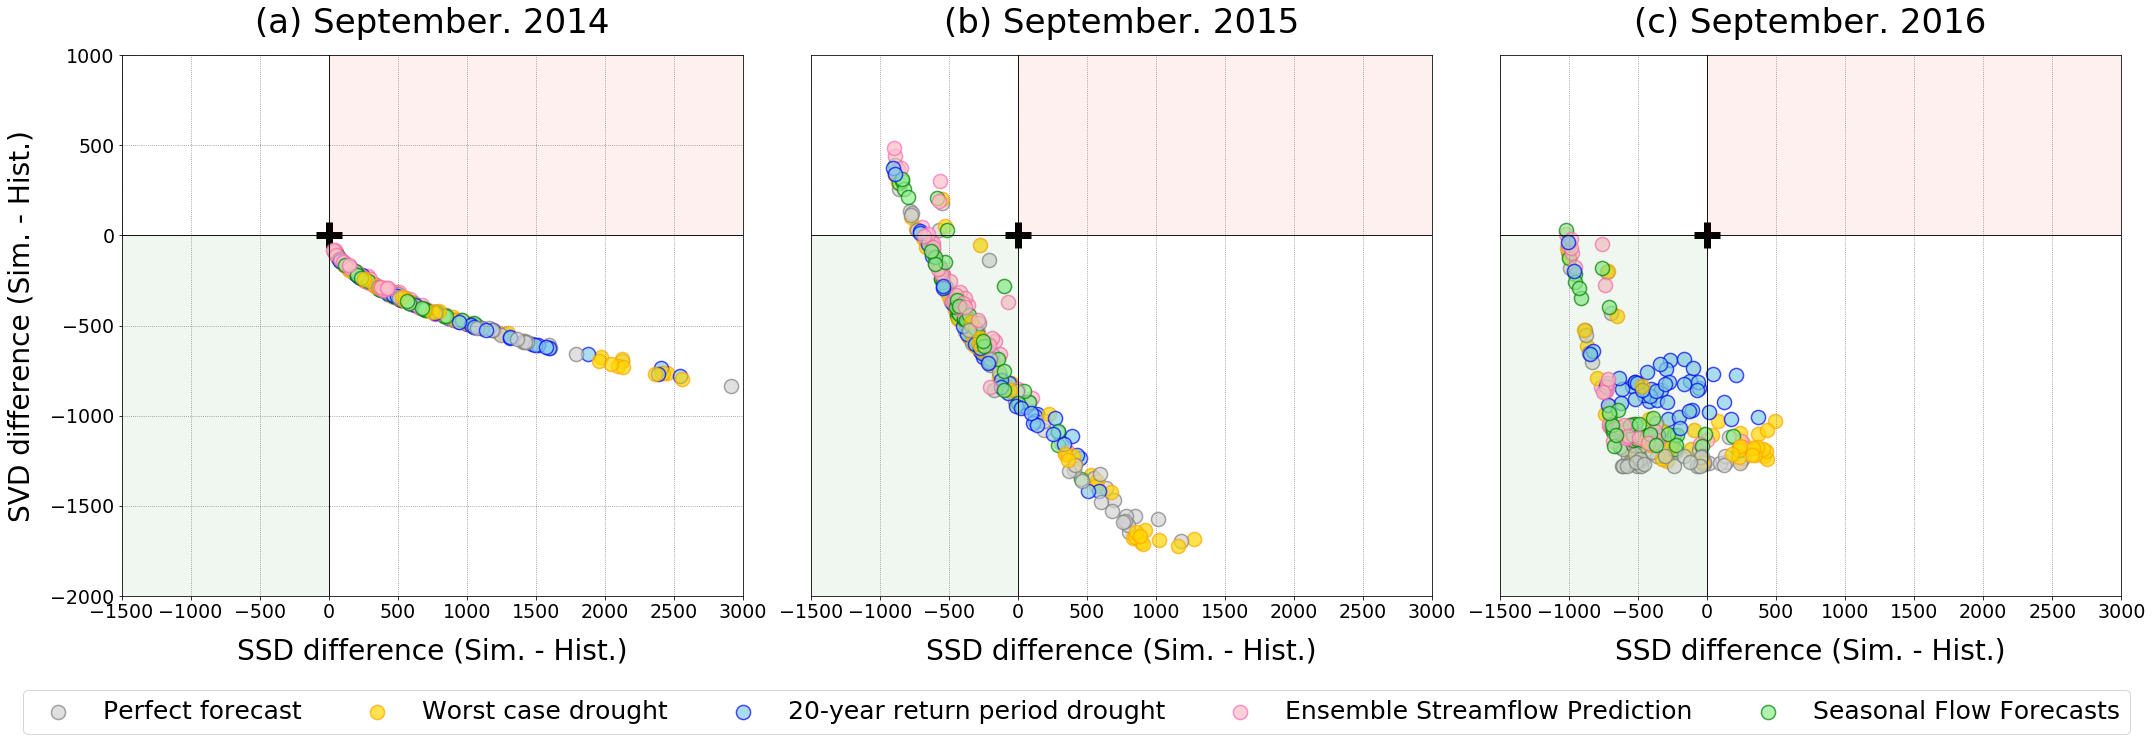

In [8]:
# Create figure and subplots
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(10*3, 10.5*1))

# Define your variables
minx = -1500
miny = -2000
maxx = 3000
maxy = 1000

start_year = 2014
start_month = 6
year_a  = 2014
month_a = 9
year_b  = 2015
month_b = 9
year_c  = 2016
month_c = 9

a_index = int(((year_a - start_year) * 12 + (month_a - start_month) + 1))*4
b_index = int(((year_b - start_year) * 12 + (month_b - start_month) + 1))*4
c_index = int(((year_c - start_year) * 12 + (month_c - start_month) + 1))*4

# Create a dictionary for labels and colors
colors = {
    1: ('lightgrey', 'grey'),
    2: ('gold', 'orange'),
    3: ('skyblue', 'blue'),
    4: ('pink', 'hotpink'),
    5: ('lightgreen', 'green')
}

# Create an empty list for legend handles
legend_handles = []

for i, (year, month, index) in enumerate([(year_a, month_a, a_index), (year_b, month_b, b_index), (year_c, month_c, c_index)]):
    ax = axes[i]
    obs = pd.read_csv(path + '/data/' +'/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)            
    obs_ssd = (obs['Supply Deficit'].iloc[1:index+1]**2).mean()
    obs_svd = obs['Volume Difference'].iloc[index]
    
    # Scatter plot
    ax.scatter(0, 0, color='black', marker='+', linewidth=7, s=700, label='Observed')

    for MCDM in range(1, 9):
        for leadtime in [2, 4, 6]:
            for decision_time in [1, 2]:
                for scenario in range(1, 6):
                    df = pd.read_csv(path + '/data/' + scenario_list[scenario] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                                      + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)
                    df_ssd = (df['Supply Deficit'].iloc[1:index+1]**2).mean()
                    df_svd = df['Volume Difference'].iloc[index]
                    color, edgecolor = colors[scenario]
                    scatter = ax.scatter(df_ssd - obs_ssd, df_svd - obs_svd, color=color, edgecolor=edgecolor, linewidth=1.5, alpha=0.7, s=200)
                    
                    # Add first scatter of each scenario to legend
                    if i == 0 and MCDM == 1 and leadtime == 2 and decision_time == 1:
                        legend_handles.append(scatter)

    # Title and formatting
    ax.set_title(f'({chr(97 + i)}) ' + calendar.month_name[month] + '. ' + str(year), x=0.5, y=1.03, fontsize=34)
    
    # Set y-axis title only for the first subplot
    if i == 0:
        ax.set_ylabel('SVD difference (Sim. - Hist.)', fontsize=28, labelpad=15)
    
    # Set x-axis title for all subplots
    ax.set_xlabel('SSD difference (Sim. - Hist.)', fontsize=28, labelpad=15)
    
    if i > 0:
        ax.set_yticks([])
    
    # Common x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=19)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.grid(True, linestyle=':', color='grey')
    ax.axhline(y=0, color='black', lw=0.9, linestyle='-')  # Horizontal central line
    ax.axvline(x=0, color='black', lw=0.9, linestyle='-')  # Vertical central line
    
    # Add patches
    ax.add_patch(Rectangle((0, 0), -3000, -3000, edgecolor=None, facecolor='green', fill=True, alpha=0.06))
    ax.add_patch(Rectangle((0, 0), 3000, 3000, edgecolor=None, facecolor='red', fill=True, alpha=0.06))

# Create a common legend below the subplots
fig.legend(handles=legend_handles, labels=['Perfect forecast', 'Worst case drought', '20-year return period drought', 'Ensemble Streamflow Prediction', 'Seasonal Flow Forecasts'], loc='lower center', ncol=5, fontsize=25)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.1, 1, 1], h_pad=1.5, w_pad=4.0)
plt.show()

### 4.4 Sensitivity of forecast value to key experimental choices

Here we show the sensitivity of forecast value (y-axis) to the choice of forecast lead time (a), MCDM method (b), decision-making time step (c) and type of flow forecast/scenario (d) for September 30th, 2016 (corresponding to c time point). The maximum number on the y-axis in each sub-figure represents the total number of simulation experiments conducted for a particular experimental set-up choice. The forecast value (y-axis) represents the number of experiments that the reservoir simulation outperforms historical operation for both objectives (SSD and SVD). For example, in the second row of Figure 7(a), the lead time is fixed at 2, 4 or 6 months (horizontal axis) and for each of these choices there are 80 experiments (see range of vertical axis), resulting from the combination of 8 MCDM methods, 2 decision-making time steps and 5 flow forecasts/scenarios. When an experimental choice (x-axis) correlates with a higher forecast value (y-axis), it indicates that using that specific experimental choice can lead to greater operational benefits for managing droughts.

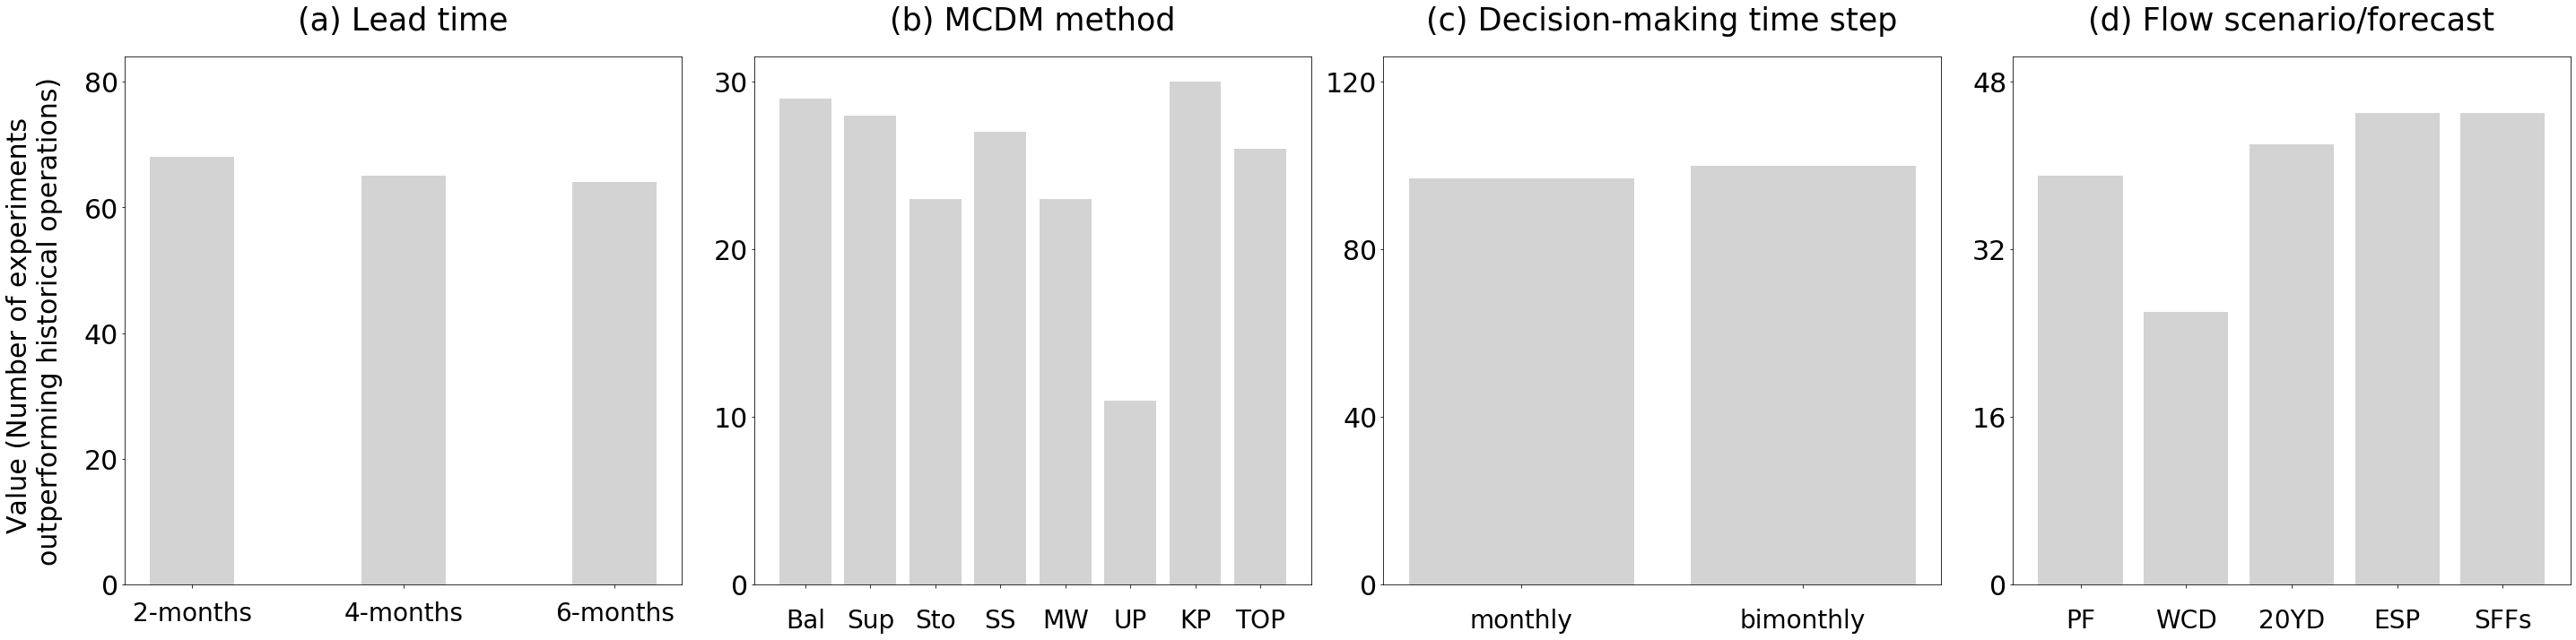

In [9]:
# Define specific time points for which results will be analyzed
year_a  = 2014
month_a = 9
year_b  = 2015
month_b = 9
year_c  = 2016
month_c = 9

# Calculate indices based on the defined years and months
a_index = int(((year_a - start_year) * 12 + (month_a - start_month) + 1)) * 4
b_index = int(((year_b - start_year) * 12 + (month_b - start_month) + 1)) * 4
c_index = int(((year_c - start_year) * 12 + (month_c - start_month) + 1)) * 4

# Choose the exact time point to show results (SSD, SVD)
timepoint = c_index
# Load observed data
obs = pd.read_csv(path + '/data/' + '/[Res_operation]' + reservoir_name + '_decision_' + str(2) + 'm_obs_merged.csv', index_col=0)
# Calculate observed Supply Deficit (SSD) and Volume Difference (SVD)
obs_ssd = (obs['Supply Deficit'].iloc[1:timepoint+1]**2).mean()
obs_svd = obs['Volume Difference'].iloc[timepoint]

# Initialize a list to store results
temp = []

# Loop through MCDM methods, lead times, decision times, and scenarios
for MCDM in range(1, 9):
    for leadtime in [2, 4, 6]:
        for decision_time in [1, 2]:
            for scenario in range(1, 6):
                # Load the corresponding result data
                df = pd.read_csv(path + '/data/' + scenario_list[scenario] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/[Res_operation]' 
                                 + reservoir_name + '_decision_' + str(decision_time) + 'm_merged.csv', index_col=0)
                # Calculate SSD and SVD for the current dataset
                df_ssd = (df['Supply Deficit'].iloc[1:timepoint+1]**2).mean()
                df_svd = df['Volume Difference'].iloc[timepoint]
                
                # Append the results (difference from observed) to the list
                temp.append([MCDM, leadtime, decision_time, scenario, df_ssd - obs_ssd, df_svd - obs_svd])

# Create a DataFrame from the collected results
df_results = pd.DataFrame(temp, columns=['MCDM', 'leadtime', 'decision_time', 'scenario', 'SSD diff', 'SVD diff'])
df_results['value'] = 0  # Initialize 'value' column
# Calculate if experiments outperform historical operations (1 for yes, 0 for no)
df_results['value'] = ((df_results['SSD diff'] < 0) & (df_results['SVD diff'] < 0)).astype(int)

# Create subplots to visualize results
fig = plt.subplots(1, 4, sharex=False, figsize=(10 * 4, 10 * 1))

# Subplot for Lead time
plt.subplot(1, 4, 1)
leadtime_sum = df_results.groupby('leadtime')['value'].sum()
# Bar chart for Lead time results
plt.bar(leadtime_sum.index, leadtime_sum.values, color='lightgrey')
plt.title('(a) Lead time', fontsize=35, x=0.5, y=1.04)
plt.tick_params(axis='x', labelsize=30, pad=15)
plt.tick_params(axis='y', labelsize=30)
plt.ylabel('Value (Number of experiments \noutperforming historical operations)', fontsize=30, labelpad=24)
plt.xticks(leadtime_sum.index, ['2-months', '4-months', '6-months'], fontsize=28, rotation=0)
plt.ylim(0, 8*2*5*1.05)  # Add 5% for better readability
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=20))  # Adjust the y-axis ticks

# Subplot for MCDM method
plt.subplot(1, 4, 2)
mcdm_sum = df_results.groupby('MCDM')['value'].sum()
# Bar chart for MCDM method results
plt.bar(mcdm_sum.index, mcdm_sum.values, color='lightgrey')
plt.title('(b) MCDM method', fontsize=35, x=0.5, y=1.04)
plt.tick_params(axis='x', labelsize=30, pad=23)
plt.tick_params(axis='y', labelsize=30)
plt.xticks(mcdm_sum.index, ['Bal', 'Sup', 'Sto', 'SS', 'MW', 'UP', 'KP', 'TOP'], fontsize=28, rotation=0)
plt.ylim(0, 3*2*5*1.05)
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10))  # Adjust the y-axis ticks

# Subplot for Decision-making time step
plt.subplot(1, 4, 3)
decision_time_sum = df_results.groupby('decision_time')['value'].sum()
# Bar chart for Decision-making time step results
plt.bar(decision_time_sum.index, decision_time_sum.values, color='lightgrey')
plt.title('(c) Decision-making time step', fontsize=35, x=0.5, y=1.04)
plt.tick_params(axis='x', labelsize=30, pad=23)
plt.tick_params(axis='y', labelsize=30)
plt.xticks(decision_time_sum.index, ['monthly', 'bimonthly'], fontsize=28, rotation=0)
plt.ylim(0, 3*8*5*1.05)
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=40))  # Adjust the y-axis ticks

# Subplot for Flow scenario/forecast
plt.subplot(1, 4, 4)
scenario_sum = df_results.groupby('scenario')['value'].sum()
# Bar chart for Flow scenario results
plt.bar(scenario_sum.index, scenario_sum.values, color='lightgrey')
plt.title('(d) Flow scenario/forecast', fontsize=35, x=0.5, y=1.04)
plt.tick_params(axis='x', labelsize=30, pad=23)
plt.tick_params(axis='y', labelsize=30)
plt.xticks(scenario_sum.index, ['PF', 'WCD', '20YD', 'ESP', 'SFFs'], fontsize=28, rotation=0)
plt.ylim(0, 3*8*2*1.05)
# Retrieve the current axis and set major locator
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=16))  # Adjust the y-axis ticks


# Adjust layout and show the plot
plt.tight_layout(h_pad=1.5, w_pad=1.5)
plt.show()

### 4.4 Relationship between forecast accuracy and value

Lastly, we will show the releationship between forecast accuracy and value (Figure 9 in the Reference paper). Specifically, this figure illustrates the overall relationship between the accuracy of each flow forecast/scenario (x-axis) and its value tallied over the 8 MCDM methods (y-axis) in informing decision-making for enhanced drought management.

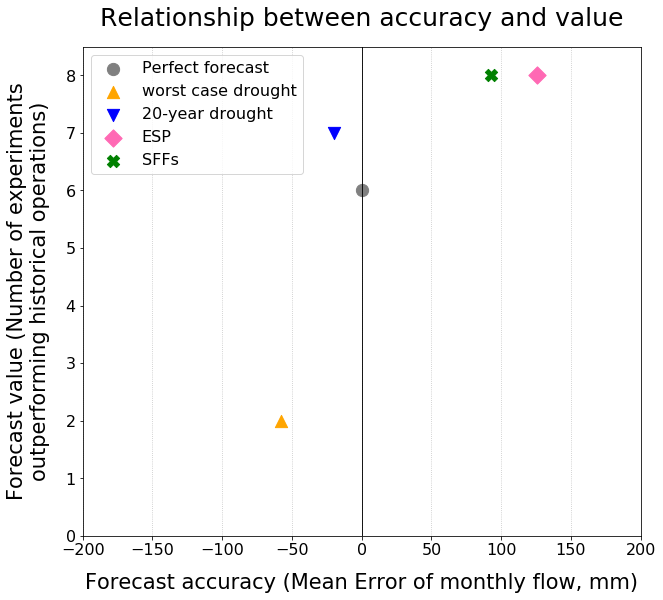

In [10]:
# Define what experimental choices you want to exclude (Here, we fix lead time and decision time step)
lt = 6 # Lead time (2 or 4 or 6)
dt = 1 # Decision time step (1 or 2)

# 1. Accuracy (Mean Error) data management for given lt 
df = df_f[df_f['leadtime'] == lt].reset_index(drop=True).iloc[:,1:]
# Insert perfect forecast scenario which has zero error
insert = pd.DataFrame({'accuracy': [0],  
    'remark': ['Perfect forecast']})
df1 = pd.concat([insert, df], ignore_index=True)

# 2. Value data management for given lt and dt
df2 = pd.DataFrame(df_results[(df_results['leadtime']==lt)&(df_results['decision_time']==dt)].groupby(['scenario'])['value'].sum()).reset_index()

df_combined = pd.concat([df1, df2.iloc[:,1:]], axis=1)  # Combine data (Accuracy and value)

# Figure
plt.figure(figsize=(10, 9))

color_map = {'Perfect forecast': 'grey', 'worst case drought': 'orange', '20-year drought':'blue',
             'ESP':'hotpink', 'SFFs':'green'}
marker_map = {'Perfect forecast': 'o', 'worst case drought': '^', '20-year drought':'v',
             'ESP':'D', 'SFFs':'X'}

for remark in df_combined['remark'].unique():
    subset = df_combined[df_combined['remark'] == remark]
    plt.scatter(subset['accuracy'], subset['value'], 
                label=remark, 
                color=color_map[remark], 
                marker=marker_map[remark],
                s=150)

plt.legend(fontsize=16)
plt.title('Relationship between accuracy and value', x=0.5, y=1.03, fontsize=25)
plt.xlabel('Forecast accuracy (Mean Error of monthly flow, mm)', fontsize =21, labelpad=15)
plt.ylabel('Forecast value (Number of experiments\noutperforming historical operations)', fontsize =21, labelpad=15)
plt.ylim(0.0, 8.5)
plt.xlim(-200, 200)
plt.axvline(x=0, color='black', lw=0.9, linestyle='-')  #수평 중앙선 삽입하기
plt.grid(True, axis='x', linestyle=':', color='grey', alpha=0.5)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.show()